# DisplacementMIP - Flood displacement impacts in the Horn of Africa

We model the annual average displacment (AAD) impacts and return periods curves for displaced people in the horn of Africa (Ethopia, Somalia, Sudan) for the displacmentMIP.

Data used:
* flood hazard maps from CIMA
* building exposure model (BEM) from [UNEP-GRID](https://giri.unepgrid.ch/sites/default/files/2023-09/GIRI_BEM_report_UNIGE.pdf)
* building level impact functions [Englhardt et al., 2019](https://nhess.copernicus.org/articles/19/1703/2019/)

Set country (Ethopia, Somalia, Sudan (SDN)); note, we do not include South Sudan (SSD).

In [1]:
# hazard
CNTRY = 'SOMALIA'

In [2]:
# exposure
cntry_name = 'Somalia'

## Make/Load Hazard

Load the return period flood maps.

In [3]:
from climada.hazard import Hazard

In [4]:
import numpy as np
from pathlib import Path

In [5]:
HAZ_TYPE = 'FL'

In [6]:
HAZ_FOLDER = Path(f'/Users/simonameiler/Documents/WCR/Displacement/Somalia_CIMA_example/Hazard/{CNTRY}/HISTORICAL/')

In [7]:
haz_files = [str(file) for file in HAZ_FOLDER.glob('*.tif')]
rp = np.array([int(Path(file).stem[-4:]) for file in haz_files])

In [8]:
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE, files_intensity=haz_files, src_crs='WGS84',
    attrs={'unit': 'm', 'event_id': np.arange(len(haz_files)), 'frequency':1/rp}
)

In [9]:
# convert intensity given in cm to m
haz.intensity = haz.intensity/100

In [10]:
haz.intensity.max(axis=1).data

array([5.56     , 6.8173584, 6.03     , 7.39     , 7.1      , 6.4      ,
       4.65     , 3.53     ])

## BEM exposure model

Load Exposures

In [11]:
from climada.entity.exposures import Exposures

In [12]:
import numpy as np
import os

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import exposure
import vulnerability

### BEM subcomponents

In [13]:
# Load the full dataframe, without further re-aggregation / processing other than adding centroids
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_name, opt='full')
gdf_bem_subcomps.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry
0,174025676,SOM,3,beds_priv,W2,0.000342,5.179267e-07,100.0,0.0,0.0,POINT (50.54583 11.86250)
1,174025676,SOM,3,beds_priv,W1,0.000146,2.214579e-07,100.0,0.0,0.0,POINT (50.54583 11.86250)
2,174025676,SOM,3,beds_priv,UCB,0.000005,7.143810e-09,100.0,0.0,0.0,POINT (50.54583 11.86250)
3,174025676,SOM,3,beds_priv,RS2,0.000038,5.715046e-08,100.0,0.0,0.0,POINT (50.54583 11.86250)
4,174025676,SOM,3,beds_priv,INF,0.000014,2.143141e-08,100.0,0.0,0.0,POINT (50.54583 11.86250)


In [14]:
# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_IVM[row.se_seismo], axis=1)

In [15]:
# replace impf 3 --> 5 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==3), "impf_FL"] = 5

In [16]:
# replace impf 4 --> 6 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==4), "impf_FL"] = 6

In [17]:
# remove for now unnecessary cols and prepare gdf for CLIMADA Exposure
gdf_bem_subcomps.rename({'valhum' : 'value'}, axis=1)
for col in ['iso3', 'sector', 'valfis', 'se_seismo']:
    gdf_bem_subcomps.pop(col)
gdf_bem_subcomps

,id_1x,cpx,valhum,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL
6,194457751,3,0.003283,0.000,0.000,0.0,POINT (43.40417 0.66250),2
7,194457751,3,0.001404,0.000,0.000,0.0,POINT (43.40417 0.66250),2
12,194457751,3,0.002711,0.000,0.000,0.0,POINT (43.40417 0.66250),2
13,194457751,3,0.001159,0.000,0.000,0.0,POINT (43.40417 0.66250),2
18,194457751,3,0.281569,0.000,0.000,0.0,POINT (43.40417 0.66250),2
...,...,...,...,...,...,...,...,...
6085408,194650976,3,2.444534,78.022,21.978,0.0,POINT (41.59583 -1.64583),2
6085409,194650976,3,0.078856,78.022,21.978,0.0,POINT (41.59583 -1.64583),6
6085410,194650976,3,0.630848,78.022,21.978,0.0,POINT (41.59583 -1.64583),5
6085411,194650976,3,0.236568,78.022,21.978,0.0,POINT (41.59583 -1.64583),1


Make CLIMADA Exposure with mutliply defined centroids

In [18]:
exp_bem = Exposures(gdf_bem_subcomps)
exp_bem.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp_bem.value_unit = 'Pop. count'
exp_bem.gdf['longitude'] = exp_bem.gdf.geometry.x
exp_bem.gdf['latitude'] = exp_bem.gdf.geometry.y
exp_bem.gdf = exp_bem.gdf[~np.isnan(
    exp_bem.gdf.latitude)]  # drop nan centroids
exp_bem.gdf.head()

,id_1x,cpx,value,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL,longitude,latitude
6,194457751,3,0.003283,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
7,194457751,3,0.001404,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
12,194457751,3,0.002711,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
13,194457751,3,0.001159,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
18,194457751,3,0.281569,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625


In [19]:
print('Total population in exposure layer: ' + "{:,.0f}".format(exp_bem.gdf.value.sum()))

Total population in exposure layer: 19,054,740


In [20]:
exp_bem.write_hdf5(f'{cntry_name}_BEM_exp.hdf5')

<GeoAxes: >

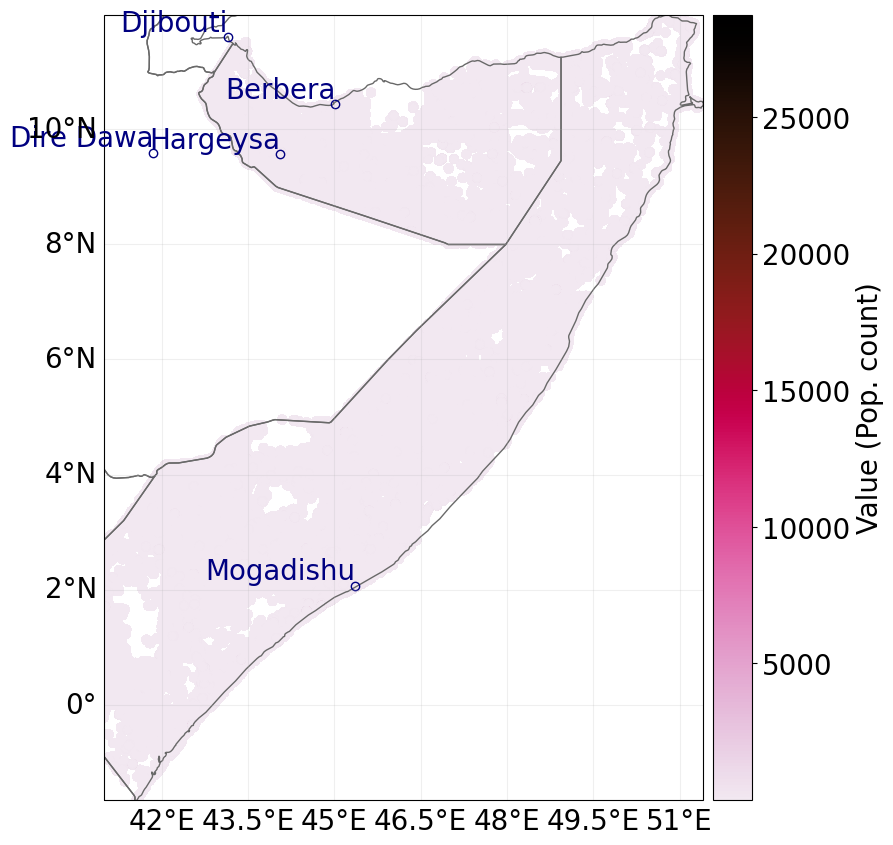

In [21]:
exp_bem.plot_scatter()

The exposure layer for Somalia includes disputed areas and Somaliland. We thus crop the extent of the exposure to the natural earth polygon.

In [22]:
if cntry_name == 'Somalia':

    import shapely
    import geopandas as gpd
    from climada.util import coordinates as u_coords
    cntry_iso = u_coords.country_to_iso(cntry_name)
    geom_cntry = shapely.ops.unary_union(
        [geom for geom in
         u_coords.get_country_geometries([cntry_iso]).geometry])
    polygon_gdf = gpd.GeoDataFrame([1], geometry=[geom_cntry], crs=gdf_bem_subcomps.crs)
    overlay_bem = gpd.sjoin(gdf_bem_subcomps, polygon_gdf, how="inner", op="intersects")
    
    print('Total population in cropped exposure layer: ' + "{:,.0f}".format(overlay_bem.value.sum()))
    
    exp = Exposures(overlay_bem)
    
else:
    exp = exp_bem

/Users/simonameiler/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Total population in cropped exposure layer: 14,134,633


In [23]:
#print('Total population in cropped exposure layer: ' + "{:,.0f}".format(overlay_bem.value.sum()))

In [24]:
#exp = Exposures(overlay_bem)

In [25]:
#exp = Exposures.from_hdf5(f'/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/{cntry_name}_BEM_exp.hdf5')

In [26]:
print('Total population in exposure layer: ' + "{:,.0f}".format(exp.gdf.value.sum()))

Total population in exposure layer: 14,134,633


## Impact functions

In [27]:
impf_set_fl = vulnerability.IMPF_SET_FL_IVM

array([[<Axes: title={'center': 'FL 1: Flood impact function class I'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: Flood impact function class II'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: Flood impact function class III - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: Flood impact function class III - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: Flood impact function class IV - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: Flood impact function class IV - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>]],
      dtype=object)

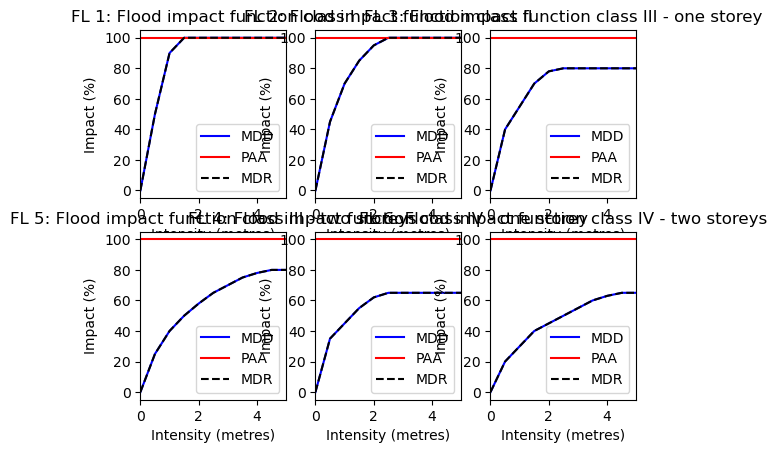

In [28]:
impf_set_fl.plot()

Generate step function from PAGER building types

In [29]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_ivm_step = ImpactFuncSet()

In [30]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_fl.get_ids(haz_type='FL'):
    impf_set_fl.get_func(fun_id=imp_id)
    y = impf_set_fl.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_fl.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_ivm_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 0.5625
ID: 2 - threshold stepfunction: 0.7000000000000002
ID: 3 - threshold stepfunction: 1.0
ID: 5 - threshold stepfunction: 1.8125000000000004
ID: 4 - threshold stepfunction: 1.5
ID: 6 - threshold stepfunction: 3.0


array([[<Axes: title={'center': 'FL 1: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>]],
      dtype=object)

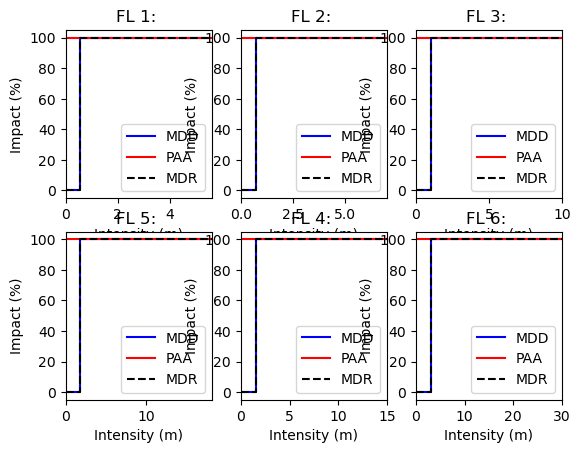

In [31]:
impf_set_ivm_step.plot()

### Impacts

#### Historical

In [32]:
from climada.engine import ImpactCalc

In [34]:
if cntry_name == 'Somalia':
    impcalc = ImpactCalc(exp, impf_set_ivm_step, haz)
    impact = impcalc.impact()
    impcalc_plus = ImpactCalc(exp_bem, impf_set_ivm_step, haz)
    impact_plus = impcalc_plus.impact()
else:
    impcalc = ImpactCalc(exp, impf_set_ivm_step, haz)
    impact = impcalc.impact()

In [35]:
if cntry_name == 'Somalia':
    print('Annual average displacement: ' + "{:,.0f}".format(impact.aai_agg))
    print('Annual average displacement + : ' + "{:,.0f}".format(impact_plus.aai_agg))
else:
    print('Annual average displacement: ' + "{:,.0f}".format(impact.aai_agg))

Annual average displacement: 104,675
Annual average displacement + : 107,376


In [36]:
if cntry_name == 'Somalia':
    freqd_curve = impact.calc_freq_curve(return_per = np.arange(1, 250, 1))
    freqd_curve_plus = impact_plus.calc_freq_curve(return_per = np.arange(1, 250, 1))
else: 
    freqd_curve = impact.calc_freq_curve(return_per = np.arange(1, 250, 1))

In [37]:
if cntry_name == 'Somalia':
    fq_dict = {'Somalia': freqd_curve,
               'Somalia +': freqd_curve_plus}
else:
    fq_dict = {cntry_name: freqd_curve}

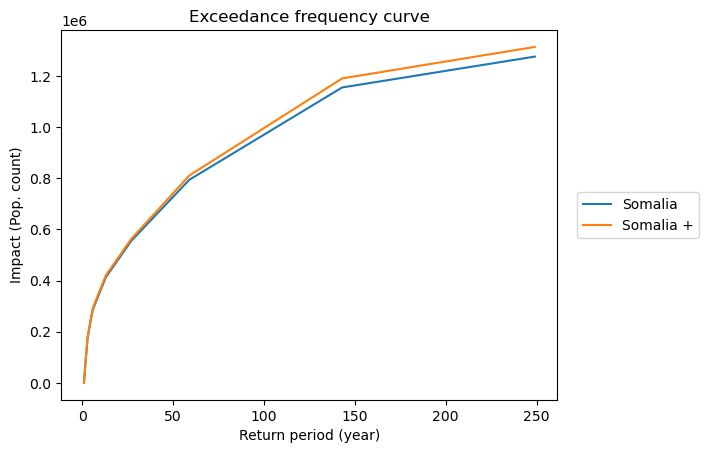

In [38]:
import matplotlib.pyplot as plt

labels = list(fq_dict.keys())

fig, axis = plt.subplots()

for i, (plots, fq) in enumerate(fq_dict.items()):
    fq.plot(axis=axis, label=labels[i])

axis.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
#axis.set_title('Exceedance frequency curve: '+str(cntry_name))

## "Validation" - comparison to iDMC database

In [39]:
import os
import pandas as pd

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import validation

In [40]:
file_path = 'data/IDMC_GIDD_Disasters_Internal_Displacement_Data.xlsx'
idmc_df = df = pd.read_excel(file_path, sheet_name='1_Disaster_Displacement_data')

In [41]:
from climada.util import coordinates as u_coords
cntry_iso = u_coords.country_to_iso(cntry_name)

In [42]:
mean = validation.extract_idmc_data(df, iso3=cntry_iso, hazard_sub_type='Flood', calculation='mean')

In [43]:
mean_2017 = validation.extract_idmc_data(df, iso3=cntry_iso, hazard_sub_type='Flood', calculation='mean', start_year=2017, end_year=None)

In [44]:
print('Reported average annual displacement - '+str(cntry_name)+': ' + "{:,.0f}".format(mean))

Reported average annual displacement - Somalia: 184,921


In [45]:
print('Reported average annual displacement 2017 onwards - '+str(cntry_name)+': ' + "{:,.0f}".format(mean_2017))

Reported average annual displacement 2017 onwards - Somalia: 360,039


## "Validation" - comparison to simple approach

Use the Global Human Settlement Layer (GHSL) for exposure and a 0.5 m and 1.0 m step function ([Kam et al., 2021](https://iopscience.iop.org/article/10.1088/1748-9326/abd26c)) for comparison.

In [46]:
exp_ghsl = exposure.exp_from_ghsl(cntry_name)

In [47]:
exp_ghsl.gdf["impf_FL"] = 1

In [48]:
exp_ghsl.gdf.head()

,longitude,latitude,value,geometry,impf_FL
0,40.966194,11.992546,0.0,POINT (40.96619 11.99255),1
1,40.976155,11.992546,0.0,POINT (40.97616 11.99255),1
2,40.986117,11.992546,0.0,POINT (40.98612 11.99255),1
3,40.996079,11.992546,0.0,POINT (40.99608 11.99255),1
4,41.006041,11.992546,0.0,POINT (41.00604 11.99255),1


In [49]:
print('Total population in GHSL exposure layer: ' + "{:,.0f}".format(exp_ghsl.gdf.value.sum()))

Total population in GHSL exposure layer: 10,459,415


Choose threshold for step function below

In [50]:
from climada.entity import ImpactFunc, ImpactFuncSet
thresh = 1.0 # set threshold flood depth for displacement
impf_step = ImpactFunc.from_step_impf(intensity=(0, thresh, 20), haz_type='FL', impf_id=1)
imp_fun_set = ImpactFuncSet([impf_step])

<Axes: title={'center': 'FL 1: '}, xlabel='Intensity ()', ylabel='Impact (%)'>

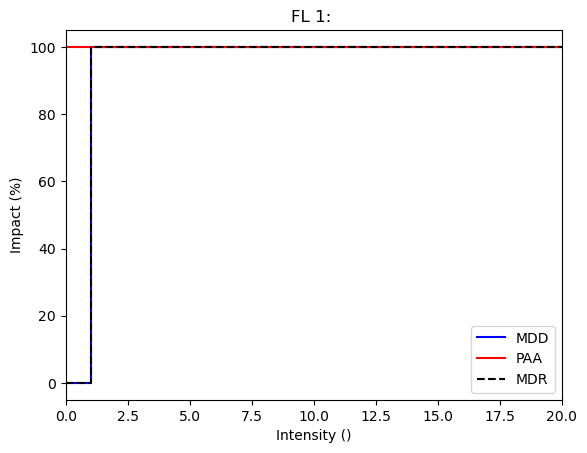

In [51]:
imp_fun_set.plot()

In [52]:
impcalc = ImpactCalc(exp_ghsl, imp_fun_set, haz)
impact_simple = impcalc.impact()

In [53]:
print('Annual average displacement: ' + "{:,.0f}".format(impact_simple.aai_agg))

Annual average displacement: 31,073
